# Tarea 2: Grad-CAM
## Óscar Esaú Peralta Rosales 
### Maestría en Ciencias de la Computación - Aprendizaje Máquina II

Grad-CAM (Gradient-weighted Class Activation Mapping) es una técnica de visualización que usa los gradientes como del algún objetivo ya sea como clasificación hacia la última capa convolucional con el fin de producir mapas de localización sobre las regiones importantes de la imagen que llevaron a obtener dicha predición.

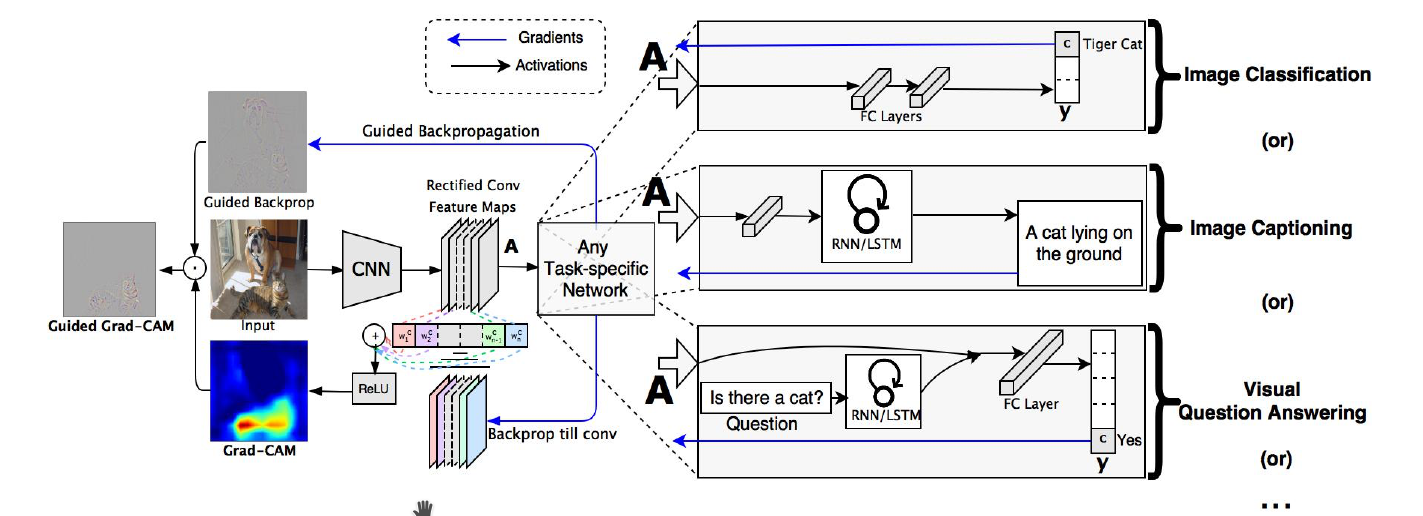

La imagen anterior ([tomada del artículo original](https://arxiv.org/abs/1610.02391)) muestra el proceso en general. Dada una imagen y una clase de interés como entrada esta es propraga a través de la parte convolucional de la red y después por la parte de resuelve cierta tarea en específico; supongamos clasificación. Todos los gradiente son puesto a cero a excepción de los de la clase deseada que se ponen en 1. Esta señal es propragada hacia atrás a través de la red hasta la capa convolucional de nuestro interés, la cual es usada para calcular el*Grad-CAM* (en bruto) que nos localiza las lugares donde el modelo se fijó para obtener el resultado. Finalmente este mapa de calor es multiplicado uno a uno con el *guided backpropagation* para obtener las visualizaciones del *Guided Grad-CAM*

## Implementación

In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

In [2]:
ENV = argparse.Namespace()

Usamos el modelo de VGG16 para clasificación

In [3]:
model = keras.applications.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


Guardamos el tamaño de las imágenes de entrada

In [4]:
ENV.img_size = model.layers[0].input_shape[0][1:]
ENV

Namespace(img_size=(224, 224, 3))

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Obtenemos la capa de interes y las capas siguientes

In [6]:
def get_last_forward_layers(model, start_conv_layer_name):
    conv_layer = None
    last_layers = []
    
    exist = False
    for layer in model.layers:
        if layer.name == start_conv_layer_name:
            conv_layer = layer
            exist = True
            continue
        if exist:
            last_layers.append(layer)
    
    return conv_layer, last_layers

Leemos la imagen a analizar

In [7]:
def get_img_array(img_path, size):
    """ Retorna la imagen original y preprocesada para el modelo VGG16 """
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    img_np = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_np.copy(), axis=0)
    return img_np, keras.applications.vgg16.preprocess_input(img_array)

Mostramos las predicciones del modelo

In [8]:
def show_predictions(img_array, top=5):
    # Imprimir las predicciones mas altas, seleccionaremos la más alta
    preds = model.predict(img_array)
    decoded_predictions=keras.applications.vgg16.decode_predictions(preds, top=top)[0]

    print("{:10} {:20} {:10}".format('Id. clase', 'Nombre', 'Probabilidad'))
    print(22*' -')
    for decoded in decoded_predictions:
        print("{:10s} {:25s} {:0.5}".format(decoded[0], decoded[1], decoded[2]))

Algoritmo de Grad-CAM.

También retornamos la saliencia, que al contrario del Grad-CAM mapea los lugares dónde se generó respuestas altas para todas las clases más problables


In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer, last_layers  = get_last_forward_layers(model, last_conv_layer_name)
    conv_model = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_model = keras.Sequential(last_layers)

    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency


Mostramos los mapas de calor sobre la imágen

In [10]:
def show_heatmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    """ Sobrepone y muestra el mapa de calor sobre un imágen """
    
    if isinstance(gs[:3], list) or isinstance(gs[:3], tuple):
        resized_heatmap = resize(heatmap[0], ENV.img_size[:2])
        for hm in heatmap[1:]:
            resized_heatmap += resize(hm, ENV.img_size[:2])
        resized_heatmap -= np.min(resized_heatmap)
        resized_heatmap = resized_heatmap / np.max(resized_heatmap)
    else:
        resized_heatmap = resize(heatmap, ENV.img_size[:2])
    fig, ax = plt.subplots()
    ax.imshow(img/255)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

In [11]:
def show_gradcam_saliency(grad_cam, saliency):
    """ Muestra los mapas de calor para Grad-CAM y S """
    plt.subplot(121)
    plt.imshow(grad_cam, 'jet')
    plt.title('GradCam')
    plt.subplot(122)
    plt.imshow(saliency, 'jet')
    plt.title('Saliencia')
    plt.show()

In [12]:
def show_heatmap_grid(heatmaps, names, image=None, alpha=0.6, cmap='jet'):
    fig = plt.figure(figsize=(20., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                    ) 

    for ax, hm, nm in zip(grid, heatmaps, names):
        # Iterating over the grid returns the Axes.
        hm = resize(hm, ENV.img_size[:2])
        if image is not None:
            ax.imshow(image/255)
            ax.imshow(hm, alpha=alpha, cmap=cmap)
        else:
            ax.imshow(hm, cmap=cmap)

        ax.axis('off')
        ax.set_title(nm)

    plt.show()

## Algunas pruebas

Descargamos una la imagen de prueba, es una gato y un perico

In [13]:
!wget https://i2.wp.com/elsecretodelosgatosfelices.com/wp-content/uploads/2013/07/Que-haces-sentado-en-mi-cola.jpg

--2020-09-17 16:31:06--  https://i2.wp.com/elsecretodelosgatosfelices.com/wp-content/uploads/2013/07/Que-haces-sentado-en-mi-cola.jpg
Resolving i2.wp.com (i2.wp.com)... 192.0.77.2
Connecting to i2.wp.com (i2.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130936 (128K) [image/jpeg]
Saving to: ‘Que-haces-sentado-en-mi-cola.jpg’

Que-haces-sentado-e 100%[===================>] 127.87K  --.-KB/s    in 0.08s   

2020-09-17 16:31:06 (1.58 MB/s) - ‘Que-haces-sentado-en-mi-cola.jpg’ saved [130936/130936]



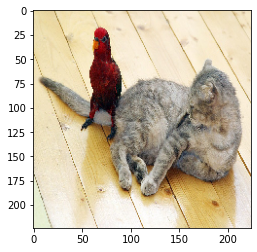

40960/35363 [==================================] - 0s 0us/step
Id. clase  Nombre               Probabilidad
 - - - - - - - - - - - - - - - - - - - - - -
n02123045  tabby                     0.22705
n01817953  African_grey              0.065916
n02124075  Egyptian_cat              0.063462
n03775071  mitten                    0.06007
n04367480  swab                      0.038105


In [14]:
img_np, img_array = get_img_array('Que-haces-sentado-en-mi-cola.jpg', ENV.img_size[:2])
plt.imshow(img_np/255)
plt.show()
show_predictions(img_array)

La preddicción mas alta es *tabby*. *Tabby* es un raza de gato conocido en español como [Gato Atigrado](https://es.wikipedia.org/wiki/Gato_atigrado)


Estos son los nombres de las capas convolucionales que usaremos para obtener el gradcam

In [15]:
names = [
    'block5_conv3',
    'block5_conv2',
    'block5_conv1',
    'block4_conv3',
    'block4_conv2',
    'block4_conv1',
    'block3_conv3',
    'block3_conv2',
    'block3_conv1',
    'block2_conv2',
    'block2_conv1',
    'block1_conv2',
]

Calculamos el gradCAM en cada capa y la saliencia

In [16]:
tmp = [make_gradcam_heatmap(img_array, model, lname) for lname in names]
gs, ss = zip(*tmp)

Saliency

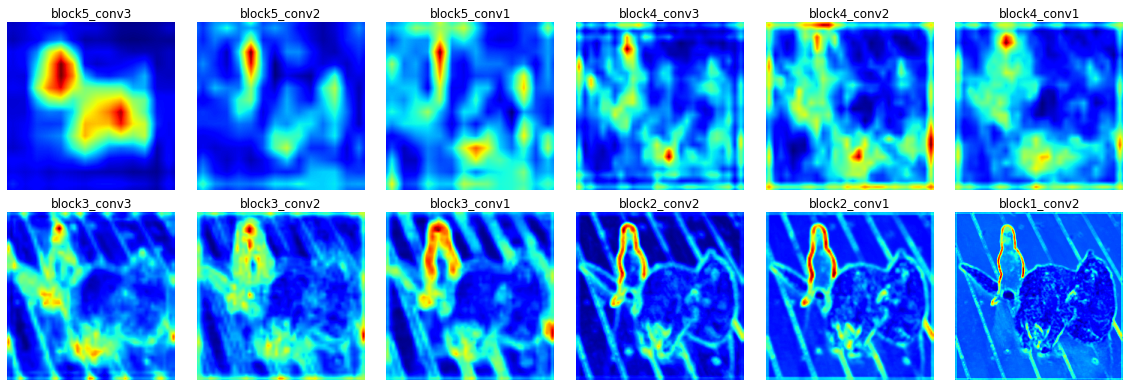

In [17]:
show_heatmap_grid(ss, names)

Grad-CAM

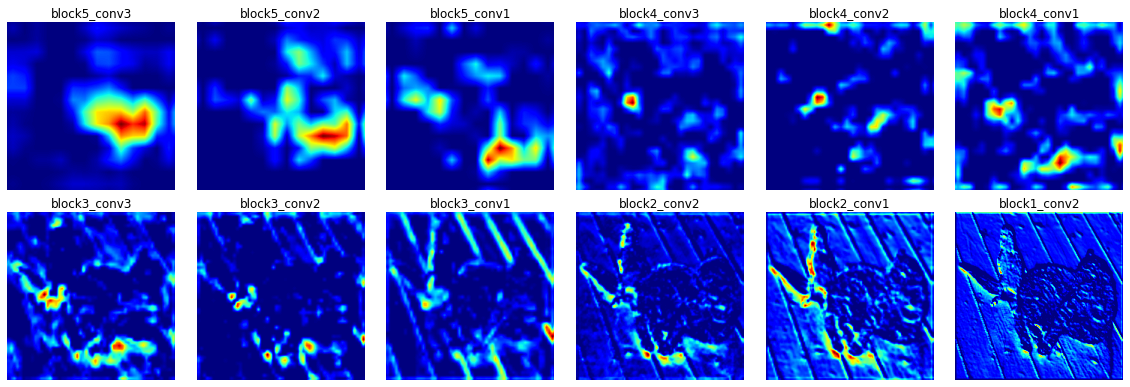

In [18]:
show_heatmap_grid(gs, names)

Saliency + Images

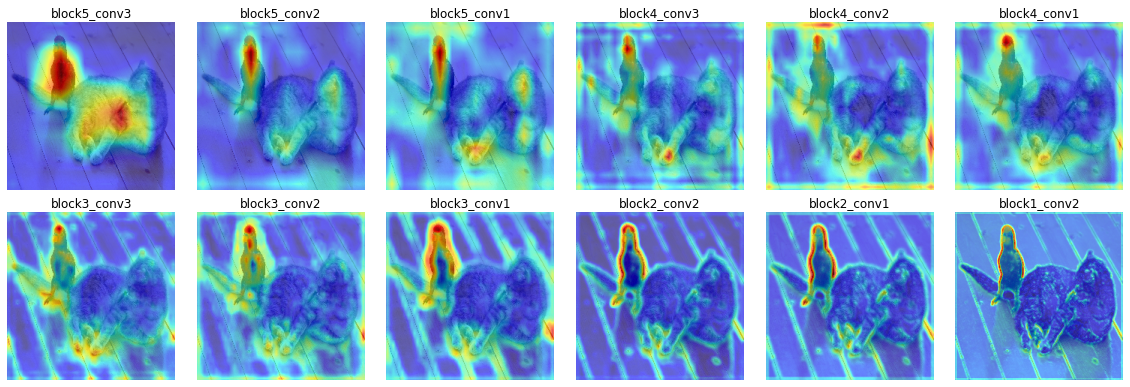

In [19]:
show_heatmap_grid(ss, names, image=img_np)

Grad-CAM + Image

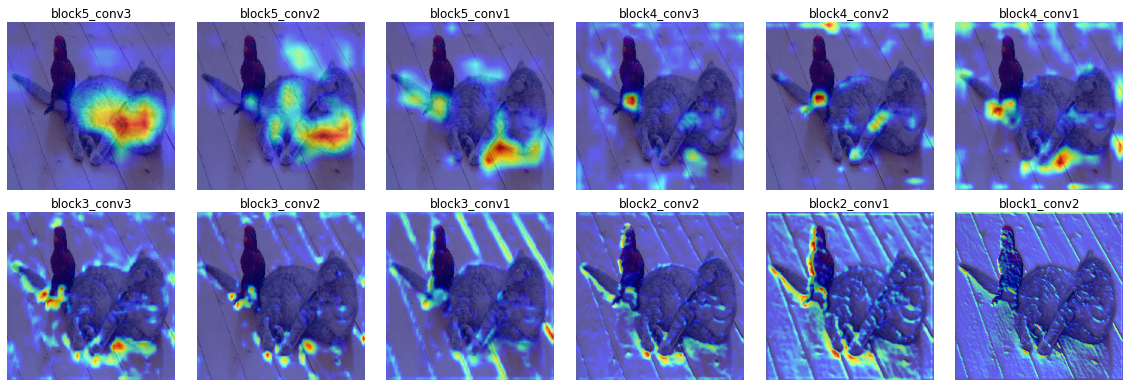

In [20]:
show_heatmap_grid(gs, names, image=img_np)

En las imágenes anteriores podemos observar que en la saliencia el mapa de calor figura en los dos animales, el gato y perico. En el GradCAM se resaltan las partes donde la red se ha fijado para saber clasificar el animal con mayor probabilidad; en este caso el gato.

Podemos notar que en las primeras capas convolucionales se resaltan los contornos de los animales como del los objetos al redodor. Lo que nos dice que las primeras capas funcionan como detectores de bordes en las imágenes. Mientras más avanzamos en profundidad las localizaciones de donde figuran los mapas de calor cambiar a zonas más concretas como las patas, pecho y cola del gato o la cabeza, pecho y patas del perico.

En la última capa convolucional observamos que el mapa de calor del GradCAM figura sobre el pecho y parte del cuerpo del gato, quizas para detectar el los patrones característicos en el pelaje de dicha raza. En capas anteriores se observa que resalta las patas y la cola. Podríamos decir muy burdamente que primero se fija en las patas y cola a ver que tipo de animal es (un gato) y después en patrones característicos para diferenciarlo mejor (un gato atígrado).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


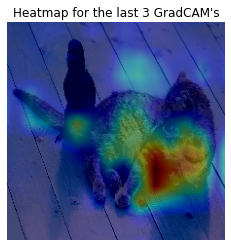

In [21]:
num_gram = 3
show_heatmap(img_array[0], gs[:num_gram], title='Heatmap for the last 3 GradCAM\'s', alpha=0.4)

En la imágen anterior se muestra la suma de los cálculos de los GradCAMS en las últimas 3 capas convolucionales, con la idea de obtener un panorama más completo de dónde se ha fijado la red para llevarla a tomar la decisión de clasificar dicho objeto como un gato. Aquí se observa mucho mejor las zonas resaltadas y discutidas previamente. El pecho, patas (delanteras) y cola del gato.

